In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

In [9]:
class DDSInstanceGenerator:
    def __init__(self, num_customers, grid_size, max_cargo_capacity, set_type="corner", random_seed=None, clients_distribution=np.random.uniform):
        # corner = allocates main depot at the (0, 0) coordinate; center = places main depot at the center
        self.num_customers = num_customers
        self.max_cargo_capacity = max_cargo_capacity
        self.grid_size = grid_size
        self.set_type = set_type
        self.clients_distribution = clients_distribution

        # Ativa a seed para reproducibilidade, se fornecida
        if random_seed is not None:
            np.random.seed(random_seed)

    def generate_delivery_and_depot_coordinates(self):

        if self.set_type == "corner":
            self.depot_coordinates = np.array([0.0, 0.0])
        else:
            self.depot_coordinates = np.array([self.grid_size/2.0, self.grid_size/2.0])

        self.customers_coordinates = self.clients_distribution(
            0, self.grid_size, size=(self.num_customers, 2)
        )

    def generate_customer_demands(self):
        self.demands = np.zeros(self.num_customers)
        split = int(0.4 * self.num_customers) # to distribute demands into groups

        self.demands[:split] = np.random.uniform(0.1, 0.7, split)
        self.demands[split:] = np.random.uniform(0.1, 1.5, self.num_customers - split)

    # computing drones so that each drone travels about 1/3 of its transport capacity
    def compute_required_drones(self):
        self.total_demand = np.sum(self.demands)

        self.allocated_drones = math.ceil(self.total_demand / (self.max_cargo_capacity / 3.0))

    # computing travel time for each delivery from depot
    def compute_travel_times(self):
        self.travel_times = np.linalg.norm(self.customers_coordinates - self.depot_coordinates, axis=1)

    # computing depot time limit:
    def compute_time_horizon(self):
        sorted_times = np.sort(self.travel_times)[::-1]
        customers_drone_ratio = math.ceil(self.num_customers / self.allocated_drones)
        total_time_spent = np.sum(sorted_times[:customers_drone_ratio])

        self.initial_operating_time = 0
        self.final_operating_time = math.ceil(2 * total_time_spent)

    def generate_time_windows(self):
        self.lower_delivery_limits = np.zeros(self.num_customers)
        self.upper_delivery_limits = np.zeros(self.num_customers)

        for customer in range(self.num_customers):
            travel_time_to_client = self.travel_times[customer]
            latest_departure = self.final_operating_time - travel_time_to_client

            # center:
            center_delivery_window = np.random.uniform(travel_time_to_client, latest_departure)

            # width
            mean_window_size = 0.25 * (latest_departure - travel_time_to_client)
            std_dev_window_size = 0.05 * (latest_departure - travel_time_to_client)
            client_window = np.random.normal(mean_window_size, std_dev_window_size)
            client_window = max(1, client_window) # avoiding degenerate windows

            client_lower_limit = max(math.ceil(travel_time_to_client), math.floor(center_delivery_window - 0.5 * client_window))
            client_upper_limit = min(math.floor(latest_departure), math.floor(center_delivery_window + 0.5 * client_window))


            self.lower_delivery_limits[customer] = client_lower_limit
            self.upper_delivery_limits[customer] = client_upper_limit

    # full pipeline (Agora com indentação correta em relação à classe)
    def generate_instances(self):
        self.generate_delivery_and_depot_coordinates()
        self.generate_customer_demands()
        self.compute_required_drones()
        self.compute_travel_times()
        self.compute_time_horizon()
        self.generate_time_windows()

    def plot(self):
        plt.figure(figsize=(10, 8))


        node_sizes = self.demands * 150

        plt.scatter(self.customers_coordinates[:, 0], self.customers_coordinates[:, 1],
                    s=node_sizes, c='dodgerblue', edgecolors='black', alpha=0.7, label='Clients (Size = Demand)')

        # Depot
        plt.scatter(self.depot_coordinates[0], self.depot_coordinates[1],
                    c='red', marker='s', s=200, edgecolors='black', label='Main Depot')

        plt.xlabel("X")
        plt.ylabel("Y")
        plt.grid(True, linestyle='--', alpha=0.6)
        plt.legend()
        plt.show()

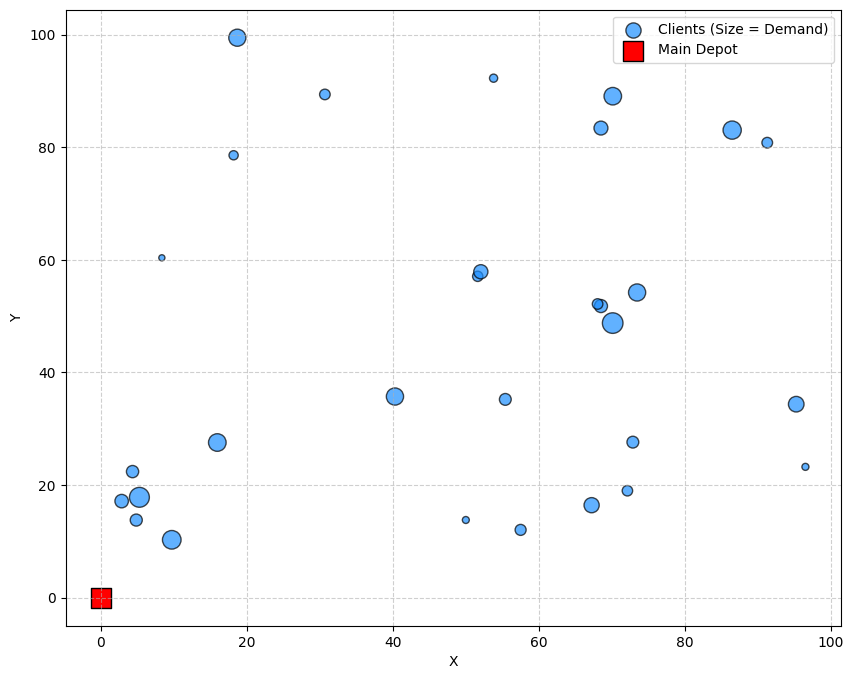

In [11]:
example = DDSInstanceGenerator(
  num_customers = 30,
  grid_size = 100,
  max_cargo_capacity = 5,
  set_type='corner',
  random_seed=101
)

example.generate_instances()

example.plot()